# 0. Import relevant packages

In [34]:
from struqture_py.spins import PauliHamiltonian
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
from qiskit.primitives import StatevectorEstimator as Estimator

import hqs_nmr

from hqs_nmr_parameters import examples
from hqs_nmr_parameters import GYROMAGNETIC_RATIOS
import hqs_nmr_parameters
from hqs_nmr_parameters.gissmo import molecules as molecules_gissmo

from utils import (
    struqture_hamiltonian_to_qiskit_op,
    xsum_eigenstate_template,
    positive_magnetization_bitstrings,
    time_signal_to_spectrum,
    spectrum_rmse,
)

import matplotlib.pyplot as plt
import numpy as np


from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
# import numpy as np
from time import perf_counter


## 1. N‑spin NMR Hamiltonian

We model an arbitrary N‑spin 1H network in liquid state. The Hamiltonian is:

$$
\hat H = -\sum_{\ell=1}^{N}\gamma_\ell\!\left(1+\delta_\ell\right) B_z\, \hat I_\ell^{\,z}
\;+\; 2\pi \sum_{k<\ell} J_{k\ell}\; \hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell
$$

with
$$
\hat{\mathbf I}_k \!\cdot\! \hat{\mathbf I}_\ell = \hat I_k^{\,x}\hat I_\ell^{\,x}+\hat I_k^{\,y}\hat I_\ell^{\,y}+\hat I_k^{\,z}\hat I_\ell^{\,z}.
$$

Parameters
- Gyromagnetic ratio (rad·s⁻¹·T⁻¹): $\gamma_\ell$ (for 1H: $\gamma/2\pi \approx 42.577\,\mathrm{MHz/T}$).
- Chemical shift (dimensionless, often reported in ppm): $\delta_\ell$.
- Static magnetic field along z (T): $B_z$.
- Isotropic scalar coupling (Hz): $J_{k\ell}$.
- Spin operators: $\hat I_k^{\alpha}$ with $\alpha\in\{x,y,z\}$.

By default, this notebook loads the liquid‑state spin Hamiltonian for cis‑3‑chloroacrylic_acid_exp at $B_0=11.7433\,\mathrm{T}$ along z. The Hamiltonian is stored as JSON produced by struqture_py (documentation: https://hqsquantumsimulations.github.io/struqture/).

At the end of the next cell, we print the PauliHamiltonian. struqture terms:
- Keys like `0Z`, `1Z`, or `0X1X` denote which Pauli acts on which spin index.
  - `iZ` means a Z operator on spin index i.
  - `0X1X` means X on spin 0 and X on spin 1 (tensor product X ⊗ X). Similarly, `0Y1Y` and `0Z1Z` are Y ⊗ Y and Z ⊗ Z between spins 0 and 1.


# 2 SPINS EXAMPLE

In [2]:
# Select a molecule based on the number of spins
number_spins = 2

if number_spins == 2:
    molecule = molecules_gissmo["bmse000368"]
    trotter_timestep = 0.01
    number_of_trottersteps = 100

elif number_spins == 5:
    molecule = examples.molecules["C6H5NO2"]
    trotter_timestep = 0.002
    number_of_trottersteps = 200

else:
    raise ValueError(
        "Please select one of the configured values (e.g., 2, 5) "
        "or select a molecule from the examples database."
    )

# Get parameters of the molecule (shifts, J values)
parameters = molecule.spin_system()

isotope_1H = hqs_nmr_parameters.Isotope(mass_number=1, symbol="H")

# Magnetic field [T]
field_T = 11.7433

# Struqture Hamiltonian in liquid
hamiltonian_struqture = hqs_nmr_parameters.nmr_hamiltonian(
    parameters=parameters, field=field_T, reference_isotope=isotope_1H
)

# Note: the Zeeman terms (iZ) are 2–3 orders of magnitude larger than the couplings.
print("Struqture Hamiltonian:\n", hamiltonian_struqture)

Struqture Hamiltonian:
 PauliHamiltonian{
0Z: -9.900257858037949e3,
1Z: -1.0014548997163773e4,
0X1X: 1.2030758912052322e1,
0Y1Y: 1.2030758912052322e1,
0Z1Z: 1.2030758912052322e1,
}


## 2. Rotating‑frame shift: subtracting the mean Z term

We subtract the mean single‑spin Z (Zeeman) term to remove the large common Larmor precession so the effective Hamiltonian has a smaller scale. A rough stability estimate for first‑order Trotterized evolution is

$ \|H_{\max}\|\,\Delta t < 1 $.

Reducing operator magnitudes via the rotating‑frame shift allows larger $\Delta t$ at similar error. The same shift must be applied back when reporting spectrum frequencies (done later via chemical_shift_hz).

In [3]:
# We are now extracting the single-qubit Z terms from the full Hamiltonian:
z_terms = []
for i in range(number_spins):
    z_terms.append(hamiltonian_struqture.get(f"{i}Z"))

# Mean of Z terms.
mean_z_parameter = np.mean(z_terms)

# Setting the chemical shift due to rotating frame of the QC calculation:
chemical_shift_hz = mean_z_parameter / (2 * np.pi)

# We now subtract the mean value of the Z coupling from the full Hamiltonian
# to arrive at the Hamiltonian that is used in the NMR calculation and store the second
# chemical shift we need to apply to the spectrum at the end.
correction_hamiltonian = PauliHamiltonian()
for i in range(number_spins):
    correction_hamiltonian.set(f"{i}Z", mean_z_parameter)

hamiltonian_struqture = hamiltonian_struqture - correction_hamiltonian

# In the rotating frame, the energies are all of order 1.
print("Hamiltonian in rotating frame: \n", hamiltonian_struqture)

Hamiltonian in rotating frame: 
 PauliHamiltonian{
0Z: 5.714556956291199e1,
1Z: -5.714556956291199e1,
0X1X: 1.2030758912052322e1,
0Y1Y: 1.2030758912052322e1,
0Z1Z: 1.2030758912052322e1,
}


## 3. Convert to Qiskit

We convert the struqture PauliHamiltonian into Qiskit’s SparsePauliOp, taking care of qubit ordering. By default we map struqture site index 0 to the rightmost character of a Qiskit Pauli label (little‑endian), matching Qiskit’s default bit ordering in many algorithms. Set reverse_qubit_order=False to keep site i as the i‑th character (big‑endian).

In [4]:
hamiltonian_qiskit = struqture_hamiltonian_to_qiskit_op(hamiltonian_struqture, number_spins)

# Qiskit representation of the Hamiltonian.
print("Hamiltonian in Qiskit:\n", hamiltonian_qiskit)

Hamiltonian in Qiskit:
 SparsePauliOp(['IZ', 'ZI', 'XX', 'YY', 'ZZ'],
              coeffs=[ 57.14556956+0.j, -57.14556956+0.j,  12.03075891+0.j,  12.03075891+0.j,
  12.03075891+0.j])


## 4. Quantum circuit for Trotterized time evolution

We now create the Trotter circuit, the initial X‑basis product states, and the measurement operators needed for time evolution.

The correlation functions needed to reconstruct the NMR spectrum are
$$
C_{xx}(t) = \mathrm{Tr}\!\big( \hat I_{x}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big), \qquad
C_{yx}(t) = \mathrm{Tr}\!\big( \hat I_{y}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big),
$$
where $\hat I_{x/y}^{\mathrm{tot}}=\sum_k \hat I_k^{x/y}$. Insert the identity in the eigenbasis of $\hat I_x^{\mathrm{tot}}(0)$ (product states in the X basis) to obtain a form evaluable with state preparation and single‑operator expectation values on a quantum computer:
$$
\mathrm{Tr}\!\big( \hat I_{\alpha}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big)
= \sum_{n} m_{x,n}(0)\, \langle m_{x,n}(0)\rvert \hat I_{\alpha}^{\mathrm{tot}}(t)\lvert m_{x,n}(0)\rangle,
\quad \alpha\in\{x,y\}.
$$
We prepare X‑basis product states $\lvert m_{x,n}(0)\rangle$, evolve them under the rotating‑frame Hamiltonian, and estimate $\langle \hat I_{x/y}^{\mathrm{tot}}(t)\rangle$ for each initial state. Summing over the initial states with weights $m_{x,n}(0)$ yields $C_{xx}(t)$ and $C_{yx}(t)$. See the references for full derivations.


### 4.1 Trotter circuit
We use first‑order Lie–Trotter product formulas (PauliEvolutionGate with LieTrotter synthesis) to approximate $U(\Delta t)=e^{-i H \Delta t}$. Increase the number of steps or use higher‑order formulas if needed.

In [5]:
# Trotter Circuit
trotter_step_first_order = PauliEvolutionGate(
    hamiltonian_qiskit, trotter_timestep, synthesis=LieTrotter()
)

trott_circuit = QuantumCircuit(hamiltonian_qiskit.num_qubits)
trott_circuit.append(trotter_step_first_order, range(hamiltonian_qiskit.num_qubits))
trott_circuit = trott_circuit.decompose(reps=1)
# trott_circuit = transpile(trott_circuit, backend=backend)


print("Trotter circuit: \n", trott_circuit)

Trotter circuit: 
       ┌────────────┐┌───────────────┐┌───────────────┐              
q_0: ─┤ Rz(1.1429) ├┤0              ├┤0              ├─■────────────
     ┌┴────────────┤│  Rxx(0.24062) ││  Ryy(0.24062) │ │ZZ(0.24062) 
q_1: ┤ Rz(-1.1429) ├┤1              ├┤1              ├─■────────────
     └─────────────┘└───────────────┘└───────────────┘              


## Alternative method: maximally mixed state + ancilla (no eigenbasis sum)

Rather than summing over the eigenbasis of $\hat I_x^{\mathrm{tot}}(0)$, insert the identity as a maximally mixed state inside the correlator:
$$
C_{\alpha x}(t)
= \mathrm{Tr}\!\big(\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big)
= \mathrm{Tr}\!\big(\mathbf{1}\,\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big)
= \mathrm{Tr}\!\big(D\,\rho_{\mathrm{mm}}\,\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big)
= D\,\mathrm{Tr}\!\big(\rho_{\mathrm{mm}}\,\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big),
\quad \rho_{\mathrm{mm}}=\frac{\mathbf{1}}{D},\ D=2^n,\ \alpha\in\{x,y\}.
$$
That is, the trace is an average over the maximally mixed state (no explicit sum over X‑basis product states needed).

Purify $\rho_{\mathrm{mm}}$ with $n$ Bell pairs between system $s$ and ancilla $a$,
$\lvert\Phi\rangle=\frac{1}{\sqrt{D}}\sum_m \lvert m\rangle_s\otimes\lvert m\rangle_a$,
and use the Choi–Jamiołkowski identity
$\mathrm{Tr}(A B)=D\,\langle\Phi|A\otimes B^{\mathsf T}|\Phi\rangle$ to obtain
$$
C_{\alpha x}(t)
= D\,\big\langle\Phi\big|\,\hat I_{\alpha}^{\mathrm{tot}}(t)\otimes\big(\hat I_x^{\mathrm{tot}}\big)^{\mathsf T}\,\big|\Phi\big\rangle
\overset{X^{\mathsf T}=X}{=}
D\,\big\langle\Phi\big|\,\hat I_{\alpha}^{\mathrm{tot}}(t)\otimes \hat I_x^{\mathrm{tot}}\,\big|\Phi\big\rangle.
$$

Circuit and estimator:
- Prepare $n$ Bell pairs: $\lvert\Phi\rangle=\bigotimes_{k=1}^n \lvert\Phi^+\rangle$.
- Evolve only the system by $U(t)$ (Trotterized).
- Measure the system in the $\alpha$ basis ($\alpha=x$: apply $H$; $\alpha=y$: apply $S^\dagger H$) and the ancilla in the $x$ basis (apply $H$); then $Z$‑measure.
- Map outcomes to eigenvalues $\pm1$; form per shot
  $S=\sum_k s_k$ (system) and $A=\sum_k a_k$ (ancilla), and average $S\cdot A$.

This yields
$$
\mathbb{E}[S\cdot A]
= \frac{1}{D}\,\mathrm{Tr}\!\big(U^\dagger(t)\,\hat I_{\alpha}^{\mathrm{tot}}\,U(t)\,\hat I_x^{\mathrm{tot}}\big)
= \frac{1}{D}\,C_{\alpha x}(t),
\qquad\Rightarrow\qquad
C_{\alpha x}(t)=D\,\mathbb{E}[S\cdot A],\ \alpha\in\{x,y\}.
$$


In [35]:
# Ancilla-assisted estimation of global NMR correlators using maximally mixed state via purification.

# We estimate:

#   C_{xx}(t) = Tr(Ĩ_x^{tot}(t) Ĩ_x^{tot}),  C_{yx}(t) = Tr(Ĩ_y^{tot}(t) Ĩ_x^{tot}),

# with Ĩ_{x/y}^{tot} = Σ_k Ĩ_k^{x/y}. The estimator uses Bell pairs and the identity 𝟙 = D·ρ_mm

# (ρ_mm = 𝟙/D), avoiding an explicit sum over the X-eigenbasis.

n = number_spins                  # number of system spins/qubits
K = number_of_trottersteps        # number of time points t_k = k·dt
dt = trotter_timestep             # Trotter step used to build U(dt)
shots = 100                       # shots per circuit
backend = AerSimulator()          # simulator backend

# trotter_step_first_order must be a Gate/Instruction acting on 'n' system qubits

# (e.g., PauliEvolutionGate(...).decompose().to_instruction()).

trotter_gate = trotter_step_first_order

timings = {}
overall_start = perf_counter()

def build_bell_circuit(n, trotter_gate, n_steps, measure_system_basis="X"):
    """
    Build the circuit that:
      1) Prepares n Bell pairs |Φ⟩^{⊗n} between system s and ancilla a (purification of ρ_mm = 𝟙/D).
      2) Applies system-only evolution U(t_k) ≈ (trotter_gate)^k, with t_k = k·dt.
      3) Measures system in {X,Y} and ancilla in X, mapping outcomes to ±1 Pauli eigenvalues.
    The circuit has 2n qubits (n system + n ancilla) and 2n classical bits.

    measure_system_basis: "X" or "Y" (ancilla always measured in X).
    """
    s = QuantumRegister(n, "s")
    a = QuantumRegister(n, "a")
    c = ClassicalRegister(2*n, "c")
    qc = QuantumCircuit(s, a, c)

    # Prepare Bell pairs |Φ+⟩ on each (s[i], a[i]): H on s[i], then CX(s[i] -> a[i]).
    for i in range(n):
        qc.h(s[i])
        qc.cx(s[i], a[i])

    # System-only evolution: apply (trotter_gate) 'n_steps' times → U(t_k) with t_k = n_steps·dt.
    for _ in range(n_steps):
        qc.append(trotter_gate, qargs=[*s])

    # Basis rotations before Z measurement:
    # - System: X via H, Y via S† then H.
    # - Ancilla: always X via H.
    for i in range(n):
        if measure_system_basis == "X":
            qc.h(s[i])
        elif measure_system_basis == "Y":
            qc.sdg(s[i])
            qc.h(s[i])
        else:
            raise ValueError("measure_system_basis must be 'X' or 'Y'")

        qc.h(a[i])  # ancilla → X basis

        # Measure system into c[i], ancilla into c[n+i]
        qc.measure(s[i], c[i])
        qc.measure(a[i], c[n + i])

    return qc

# Build circuits for times t_k = k·dt:

build_start = perf_counter()
circuits = []
meta = []  # track which circuit corresponds to which correlator and time index
for k in range(K):
    circ_xx = build_bell_circuit(n, trotter_gate, n_steps=k, measure_system_basis="X")
    circ_yx = build_bell_circuit(n, trotter_gate, n_steps=k, measure_system_basis="Y")
    circuits.append(circ_xx); meta.append(("xx", k))
    circuits.append(circ_yx); meta.append(("yx", k))
build_end = perf_counter()
timings["build_circuits"] = build_end - build_start

# Transpile to unroll composite instructions into Aer basis gates

transpile_start = perf_counter()
circuits = transpile(circuits, backend=backend)
transpile_end = perf_counter()
timings["transpile"] = transpile_end - transpile_start

# Execute with memory=True to get per-shot bitstrings for the estimator

run_call_start = perf_counter()
job = backend.run(circuits, shots=shots, memory=True)
run_call_end = perf_counter()
timings["backend_run_call"] = run_call_end - run_call_start

# Wait for simulation result (dominant runtime for large circuits)

wait_start = perf_counter()
result = job.result()
wait_end = perf_counter()
timings["simulate_wait_job_result"] = wait_end - wait_start

# Arrays for normalized correlators: C_{αx}^{norm}(t_k) = (1/D)·Tr(...), with D = 2^n

Cxx_norm = np.zeros(K, dtype=float)
Cyx_norm = np.zeros(K, dtype=float)
D = 2 ** n

# Parse shot results and compute the ancilla-assisted estimator:

# E[S·A] = (1/D)·Tr(U†(t_k) Ĩ_α^{tot} U(t_k) Ĩ_x^{tot}) = (1/D)·C_{αx}(t_k).

post_total = 0.0
mem_fetch_total = 0.0
parse_total = 0.0

post_start = perf_counter()
for exp_idx, (tag, k) in enumerate(meta):
    mem_start = perf_counter()
    memories = result.get_memory(exp_idx)  # list[str], one bitstring per shot
    mem_end = perf_counter()
    mem_fetch_total += mem_end - mem_start

    parse_start = perf_counter()
    products = np.empty(len(memories), dtype=np.int64)

    for shot_i, mem in enumerate(memories):
        bits = mem[::-1]            # reverse: align c[0] with first char (Aer is typically MSB-first)
        sys_bits = bits[:n]         # system measurements c[0..n-1]
        anc_bits = bits[n:2*n]      # ancilla measurements c[n..2n-1]

        # Map Z outcomes to ±1 Pauli eigenvalues: 0 → +1, 1 → −1
        s_vals = np.fromiter((1 if b == "0" else -1 for b in sys_bits), dtype=np.int8)
        a_vals = np.fromiter((1 if b == "0" else -1 for b in anc_bits), dtype=np.int8)

        # Global sums: S = Σ_i s_i, A = Σ_j a_j; estimator uses product S·A
        products[shot_i] = int(s_vals.sum()) * int(a_vals.sum())
        # Diagonal variant: products[shot_i] = int((s_vals * a_vals).sum())

    mean_prod = products.mean()  # estimator: E[S·A] = (1/D)·C_{αx}(t_k)
    if tag == "xx":
        Cxx_norm[k] = mean_prod
    else:  # "yx"
        Cyx_norm[k] = mean_prod
    parse_end = perf_counter()
    parse_total += parse_end - parse_start

post_end = perf_counter()
post_total = post_end - post_start
timings["postprocess_total"] = post_total
timings["postprocess_fetch_memory"] = mem_fetch_total
timings["postprocess_parse_products"] = parse_total


# --- apply a single exponential window before FFT ---
noise_strength = 3.0  # s^-1 (choose per system/step size)
times = np.arange(number_of_trottersteps) * trotter_timestep
window = np.exp(-noise_strength * times)
Cxx_norm = Cxx_norm * window
Cyx_norm = Cyx_norm * window

# Convert normalized values to traces: C_{αx}(t_k) = D · C_{αx}^{norm}(t_k)

Cxx_trace = D * Cxx_norm
Cyx_trace = D * Cyx_norm

# Time grid

times = np.arange(K) * dt

# Results

print("times:", times)
print("C_xx (normalized 1/D * Tr):", Cxx_norm)
print("C_yx (normalized 1/D * Tr):", Cyx_norm)
print("C_xx (trace):", Cxx_trace)
print("C_yx (trace):", Cyx_trace)

overall_end = perf_counter()
timings["overall_total"] = overall_end - overall_start

# Timing summary

print("\nTiming summary (seconds):")
for k, v in timings.items():
    print(f"  {k:30s}: {v:.6f}")

# Optional: highlight the most expensive step

max_key = max(timings, key=timings.get)
print(f"\nMost expensive step: {max_key} ({timings[max_key]:.6f} s)")

/home/dallara/hqstage/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/dallara/hqstage/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/dallara/hqstage/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/home/dallara/hqstage/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/home/dallara/hqstage/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/dallara/hqstage/lib/python3.12/site

times: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]
C_xx (normalized 1/D * Tr): [ 2.12        0.42699603 -0.94176453 -0.91393119 -0.35476817  0.24099823
  0.03341081  0.06484674  0.47197672  0.58016842 -0.59265458 -1.15027797
 -0.50232695  1.24578465  1.1564024  -0.07651538 -0.6930374  -0.55245593
 -0.02330993  0.42979933  0.0658574   0.04260734  0.18606648 -0.12037826
 -0.87615406 -0.47236655  0.45840601  0.9430991   0.37990526 -0.45246767
 -0.48788359 -0.07891074  0.21442002  0.0445892   0.20193317  0.36393526
  0.12225439 -0.46

## Shot error and measurement scaling

- Per shot, you estimate the normalized correlator via
  - X = S · A, with S = ∑_i s_i and A = ∑_j a_j, where s_i, a_j ∈ {±1}.
  - The sample mean has standard error SE = sqrt(Var[X] / N_shots).

- Bounds and typical behavior:
  - Since |S| ≤ n and |A| ≤ n, |X| ≤ n^2 ⇒ Var[X] ≤ n^4 (worst case).
    Therefore SE ≤ n^2 / √N_shots, so to reach absolute error ε on the normalized correlator:
    $$N_{\text{shots}} = O\!\left(\frac{n^4}{\varepsilon^2}\right) \quad \text{(worst case)}.$$


Takeaway: for fixed absolute error on the normalized correlator (or fixed relative error on the trace), the shot complexity is polynomial in n—typically O(n^2/ε^2), worst‑case O(n^4/ε^2).

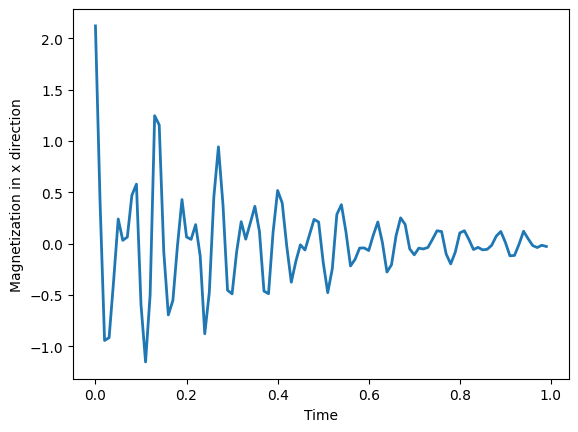

In [42]:
plt.figure(dpi=100)
plt.plot(times, Cxx_norm, color="C0", lw=2.0)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Magnetization in x direction", fontsize=10)
plt.show()

In [43]:
# Larmor/reference frequency in Hz at the given field.
reference_energy_hz = GYROMAGNETIC_RATIOS[isotope_1H] * field_T / (2 * np.pi)

# Conversion factor to go from Hz to ppm at this field: ppm = (Hz) * (1e6 / v0)
Hz_to_ppm_conversion = 1e6 / reference_energy_hz

spectrum_full, ppm = time_signal_to_spectrum(
    Cxx_norm,
    Cyx_norm,
    trotter_timestep,
    number_of_trottersteps,
    Hz_to_ppm_conversion=Hz_to_ppm_conversion,
    chem_shift_hz=chemical_shift_hz,
)

# spectrum_full, ppm = time_signal_to_spectrum(
#     Cxx_trace,
#     Cyx_trace,
#     trotter_timestep,
#     number_of_trottersteps,
#     Hz_to_ppm_conversion=Hz_to_ppm_conversion,
#     chem_shift_hz=chemical_shift_hz,
# )

In [44]:
solver_settings = hqs_nmr.NMRSolverSettings()
calculation_parameters = hqs_nmr.NMRCalculationParameters(
    field_T=field_T,
    fwhm_Hz=1.0,
    solver_settings=solver_settings,
)
result_spectrum_exact = hqs_nmr.calculate.calculate_spectrum(
    molecule_parameters=parameters, calculation_parameters=calculation_parameters
)

hqs_spectrum_tools_ppm = result_spectrum_exact.spectrum.omegas_ppm
hqs_spectrum_tools_spectrum = np.sum(result_spectrum_exact.spectrum.spin_contributions, axis=0)
hqs_spectrum_tools_spectrum /= np.max(hqs_spectrum_tools_spectrum)

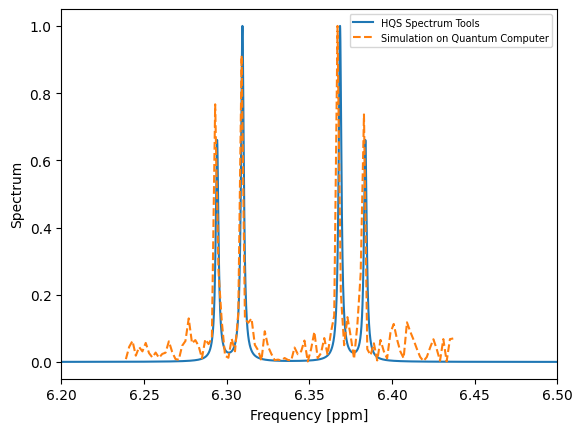

In [45]:
plt.figure(dpi=100)
plt.plot(
    hqs_spectrum_tools_ppm, hqs_spectrum_tools_spectrum, color="C0", label="HQS Spectrum Tools"
)
plt.plot(ppm, spectrum_full, color="C1", ls="--", label="Simulation on Quantum Computer")
# plt.plot(ppm_0, spectrum_full_0, color="C4", ls="--", label="Alternative")

plt.xlim(6.2, 6.5)
plt.xlabel("Frequency [ppm]")
plt.ylabel("Spectrum")
plt.legend(fontsize=7)
plt.show()

# 5 SPINS EXAMPLE

In [46]:
# Select a molecule based on the number of spins
number_spins = 5

if number_spins == 2:
    molecule = molecules_gissmo["bmse000368"]
    trotter_timestep = 0.01
    number_of_trottersteps = 100

elif number_spins == 5:
    molecule = examples.molecules["C6H5NO2"]
    trotter_timestep = 0.002
    number_of_trottersteps = 200

else:
    raise ValueError(
        "Please select one of the configured values (e.g., 2, 5) "
        "or select a molecule from the examples database."
    )

# Get parameters of the molecule (shifts, J values)
parameters = molecule.spin_system()

isotope_1H = hqs_nmr_parameters.Isotope(mass_number=1, symbol="H")

# Magnetic field [T]
field_T = 11.7433

# Struqture Hamiltonian in liquid
hamiltonian_struqture = hqs_nmr_parameters.nmr_hamiltonian(
    parameters=parameters, field=field_T, reference_isotope=isotope_1H
)

# Note: the Zeeman terms (iZ) are 2–3 orders of magnitude larger than the couplings.
print("Struqture Hamiltonian:\n", hamiltonian_struqture)

Struqture Hamiltonian:
 PauliHamiltonian{
0Z: -1.1875220049858093e4,
1Z: -1.2927653572559357e4,
2Z: -1.2927653572559357e4,
3Z: -1.1875220049858093e4,
4Z: -1.2110839495420456e4,
0X1X: 1.3194689145077131e1,
0Y1Y: 1.3194689145077131e1,
0Z1Z: 1.3194689145077131e1,
0X2X: 9.424777960769379e-1,
0Y2Y: 9.424777960769379e-1,
0Z2Z: 9.424777960769379e-1,
0X3X: 2.356194490192345e0,
0Y3Y: 2.356194490192345e0,
0Z3Z: 2.356194490192345e0,
0X4X: 1.1780972450961723e1,
0Y4Y: 1.1780972450961723e1,
0Z4Z: 1.1780972450961723e1,
1X2X: 3.7699111843077517e0,
1Y2Y: 3.7699111843077517e0,
1Z2Z: 3.7699111843077517e0,
1X3X: 9.424777960769379e-1,
1Y3Y: 9.424777960769379e-1,
1Z3Z: 9.424777960769379e-1,
1X4X: 1.8849555921538759e0,
1Y4Y: 1.8849555921538759e0,
1Z4Z: 1.8849555921538759e0,
2X3X: 1.3194689145077131e1,
2Y3Y: 1.3194689145077131e1,
2Z3Z: 1.3194689145077131e1,
2X4X: 1.8849555921538759e0,
2Y4Y: 1.8849555921538759e0,
2Z4Z: 1.8849555921538759e0,
3X4X: 1.1780972450961723e1,
3Y4Y: 1.1780972450961723e1,
3Z4Z: 1.178097

## 2. Rotating‑frame shift: subtracting the mean Z term

We subtract the mean single‑spin Z (Zeeman) term to remove the large common Larmor precession so the effective Hamiltonian has a smaller scale. A rough stability estimate for first‑order Trotterized evolution is

$ \|H_{\max}\|\,\Delta t < 1 $.

Reducing operator magnitudes via the rotating‑frame shift allows larger $\Delta t$ at similar error. The same shift must be applied back when reporting spectrum frequencies (done later via chemical_shift_hz).

In [47]:
# We are now extracting the single-qubit Z terms from the full Hamiltonian:
z_terms = []
for i in range(number_spins):
    z_terms.append(hamiltonian_struqture.get(f"{i}Z"))

# Mean of Z terms.
mean_z_parameter = np.mean(z_terms)

# Setting the chemical shift due to rotating frame of the QC calculation:
chemical_shift_hz = mean_z_parameter / (2 * np.pi)

# We now subtract the mean value of the Z coupling from the full Hamiltonian
# to arrive at the Hamiltonian that is used in the NMR calculation and store the second
# chemical shift we need to apply to the spectrum at the end.
correction_hamiltonian = PauliHamiltonian()
for i in range(number_spins):
    correction_hamiltonian.set(f"{i}Z", mean_z_parameter)

hamiltonian_struqture = hamiltonian_struqture - correction_hamiltonian

# In the rotating frame, the energies are all of order 1.
print("Hamiltonian in rotating frame: \n", hamiltonian_struqture)

Hamiltonian in rotating frame: 
 PauliHamiltonian{
0Z: 4.680972981929772e2,
1Z: -5.843362245082863e2,
2Z: -5.843362245082863e2,
3Z: 4.680972981929772e2,
4Z: 2.324778526306145e2,
0X1X: 1.3194689145077131e1,
0Y1Y: 1.3194689145077131e1,
0Z1Z: 1.3194689145077131e1,
0X2X: 9.424777960769379e-1,
0Y2Y: 9.424777960769379e-1,
0Z2Z: 9.424777960769379e-1,
0X3X: 2.356194490192345e0,
0Y3Y: 2.356194490192345e0,
0Z3Z: 2.356194490192345e0,
0X4X: 1.1780972450961723e1,
0Y4Y: 1.1780972450961723e1,
0Z4Z: 1.1780972450961723e1,
1X2X: 3.7699111843077517e0,
1Y2Y: 3.7699111843077517e0,
1Z2Z: 3.7699111843077517e0,
1X3X: 9.424777960769379e-1,
1Y3Y: 9.424777960769379e-1,
1Z3Z: 9.424777960769379e-1,
1X4X: 1.8849555921538759e0,
1Y4Y: 1.8849555921538759e0,
1Z4Z: 1.8849555921538759e0,
2X3X: 1.3194689145077131e1,
2Y3Y: 1.3194689145077131e1,
2Z3Z: 1.3194689145077131e1,
2X4X: 1.8849555921538759e0,
2Y4Y: 1.8849555921538759e0,
2Z4Z: 1.8849555921538759e0,
3X4X: 1.1780972450961723e1,
3Y4Y: 1.1780972450961723e1,
3Z4Z: 1.17809

## 3. Convert to Qiskit

We convert the struqture PauliHamiltonian into Qiskit’s SparsePauliOp, taking care of qubit ordering. By default we map struqture site index 0 to the rightmost character of a Qiskit Pauli label (little‑endian), matching Qiskit’s default bit ordering in many algorithms. Set reverse_qubit_order=False to keep site i as the i‑th character (big‑endian).

In [48]:
hamiltonian_qiskit = struqture_hamiltonian_to_qiskit_op(hamiltonian_struqture, number_spins)

# Qiskit representation of the Hamiltonian.
print("Hamiltonian in Qiskit:\n", hamiltonian_qiskit)

Hamiltonian in Qiskit:
 SparsePauliOp(['IIIIZ', 'IIIZI', 'IIZII', 'IZIII', 'ZIIII', 'IIIXX', 'IIIYY', 'IIIZZ', 'IIXIX', 'IIYIY', 'IIZIZ', 'IXIIX', 'IYIIY', 'IZIIZ', 'XIIIX', 'YIIIY', 'ZIIIZ', 'IIXXI', 'IIYYI', 'IIZZI', 'IXIXI', 'IYIYI', 'IZIZI', 'XIIXI', 'YIIYI', 'ZIIZI', 'IXXII', 'IYYII', 'IZZII', 'XIXII', 'YIYII', 'ZIZII', 'XXIII', 'YYIII', 'ZZIII'],
              coeffs=[ 468.09729819+0.j, -584.33622451+0.j, -584.33622451+0.j,
  468.09729819+0.j,  232.47785263+0.j,   13.19468915+0.j,
   13.19468915+0.j,   13.19468915+0.j,    0.9424778 +0.j,
    0.9424778 +0.j,    0.9424778 +0.j,    2.35619449+0.j,
    2.35619449+0.j,    2.35619449+0.j,   11.78097245+0.j,
   11.78097245+0.j,   11.78097245+0.j,    3.76991118+0.j,
    3.76991118+0.j,    3.76991118+0.j,    0.9424778 +0.j,
    0.9424778 +0.j,    0.9424778 +0.j,    1.88495559+0.j,
    1.88495559+0.j,    1.88495559+0.j,   13.19468915+0.j,
   13.19468915+0.j,   13.19468915+0.j,    1.88495559+0.j,
    1.88495559+0.j,    1.88495559+0.j,   11.

## 4. Quantum circuit for Trotterized time evolution

We now create the Trotter circuit, the initial X‑basis product states, and the measurement operators needed for time evolution.

The correlation functions needed to reconstruct the NMR spectrum are
$$
C_{xx}(t) = \mathrm{Tr}\!\big( \hat I_{x}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big), \qquad
C_{yx}(t) = \mathrm{Tr}\!\big( \hat I_{y}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big),
$$
where $\hat I_{x/y}^{\mathrm{tot}}=\sum_k \hat I_k^{x/y}$. Insert the identity in the eigenbasis of $\hat I_x^{\mathrm{tot}}(0)$ (product states in the X basis) to obtain a form evaluable with state preparation and single‑operator expectation values on a quantum computer:
$$
\mathrm{Tr}\!\big( \hat I_{\alpha}^{\mathrm{tot}}(t)\, \hat I_x^{\mathrm{tot}}(0)\big)
= \sum_{n} m_{x,n}(0)\, \langle m_{x,n}(0)\rvert \hat I_{\alpha}^{\mathrm{tot}}(t)\lvert m_{x,n}(0)\rangle,
\quad \alpha\in\{x,y\}.
$$
We prepare X‑basis product states $\lvert m_{x,n}(0)\rangle$, evolve them under the rotating‑frame Hamiltonian, and estimate $\langle \hat I_{x/y}^{\mathrm{tot}}(t)\rangle$ for each initial state. Summing over the initial states with weights $m_{x,n}(0)$ yields $C_{xx}(t)$ and $C_{yx}(t)$. See the references for full derivations.


### 4.1 Trotter circuit
We use first‑order Lie–Trotter product formulas (PauliEvolutionGate with LieTrotter synthesis) to approximate $U(\Delta t)=e^{-i H \Delta t}$. Increase the number of steps or use higher‑order formulas if needed.

In [49]:
# Trotter Circuit
trotter_step_first_order = PauliEvolutionGate(
    hamiltonian_qiskit, trotter_timestep, synthesis=LieTrotter()
)

trott_circuit = QuantumCircuit(hamiltonian_qiskit.num_qubits)
trott_circuit.append(trotter_step_first_order, range(hamiltonian_qiskit.num_qubits))
trott_circuit = trott_circuit.decompose(reps=1)
# trott_circuit = transpile(trott_circuit, backend=backend)


print("Trotter circuit: \n", trott_circuit)

Trotter circuit: 
       ┌────────────┐┌────────────────┐┌────────────────┐               »
q_0: ─┤ Rz(1.8724) ├┤0               ├┤0               ├─■─────────────»
     ┌┴────────────┤│  Rxx(0.052779) ││  Ryy(0.052779) │ │ZZ(0.052779) »
q_1: ┤ Rz(-2.3373) ├┤1               ├┤1               ├─■─────────────»
     ├─────────────┤└────────────────┘└────────────────┘               »
q_2: ┤ Rz(-2.3373) ├───────────────────────────────────────────────────»
     └┬────────────┤                                                   »
q_3: ─┤ Rz(1.8724) ├───────────────────────────────────────────────────»
     ┌┴────────────┤                                                   »
q_4: ┤ Rz(0.92991) ├───────────────────────────────────────────────────»
     └─────────────┘                                                   »
«     ┌─────────────────┐┌─────────────────┐                                 »
«q_0: ┤0                ├┤0                ├─■───────────────────────────────»
«     │             

## Alternative method: maximally mixed state + ancilla (no eigenbasis sum)

Rather than summing over the eigenbasis of $\hat I_x^{\mathrm{tot}}(0)$, insert the identity as a maximally mixed state inside the correlator:
$$
C_{\alpha x}(t)
= \mathrm{Tr}\!\big(\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big)
= \mathrm{Tr}\!\big(\mathbf{1}\,\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big)
= \mathrm{Tr}\!\big(D\,\rho_{\mathrm{mm}}\,\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big)
= D\,\mathrm{Tr}\!\big(\rho_{\mathrm{mm}}\,\hat I_{\alpha}^{\mathrm{tot}}(t)\,\hat I_x^{\mathrm{tot}}\big),
\quad \rho_{\mathrm{mm}}=\frac{\mathbf{1}}{D},\ D=2^n,\ \alpha\in\{x,y\}.
$$
That is, the trace is an average over the maximally mixed state (no explicit sum over X‑basis product states needed).

Purify $\rho_{\mathrm{mm}}$ with $n$ Bell pairs between system $s$ and ancilla $a$,
$\lvert\Phi\rangle=\frac{1}{\sqrt{D}}\sum_m \lvert m\rangle_s\otimes\lvert m\rangle_a$,
and use the Choi–Jamiołkowski identity
$\mathrm{Tr}(A B)=D\,\langle\Phi|A\otimes B^{\mathsf T}|\Phi\rangle$ to obtain
$$
C_{\alpha x}(t)
= D\,\big\langle\Phi\big|\,\hat I_{\alpha}^{\mathrm{tot}}(t)\otimes\big(\hat I_x^{\mathrm{tot}}\big)^{\mathsf T}\,\big|\Phi\big\rangle
\overset{X^{\mathsf T}=X}{=}
D\,\big\langle\Phi\big|\,\hat I_{\alpha}^{\mathrm{tot}}(t)\otimes \hat I_x^{\mathrm{tot}}\,\big|\Phi\big\rangle.
$$

Circuit and estimator:
- Prepare $n$ Bell pairs: $\lvert\Phi\rangle=\bigotimes_{k=1}^n \lvert\Phi^+\rangle$.
- Evolve only the system by $U(t)$ (Trotterized).
- Measure the system in the $\alpha$ basis ($\alpha=x$: apply $H$; $\alpha=y$: apply $S^\dagger H$) and the ancilla in the $x$ basis (apply $H$); then $Z$‑measure.
- Map outcomes to eigenvalues $\pm1$; form per shot
  $S=\sum_k s_k$ (system) and $A=\sum_k a_k$ (ancilla), and average $S\cdot A$.

This yields
$$
\mathbb{E}[S\cdot A]
= \frac{1}{D}\,\mathrm{Tr}\!\big(U^\dagger(t)\,\hat I_{\alpha}^{\mathrm{tot}}\,U(t)\,\hat I_x^{\mathrm{tot}}\big)
= \frac{1}{D}\,C_{\alpha x}(t),
\qquad\Rightarrow\qquad
C_{\alpha x}(t)=D\,\mathbb{E}[S\cdot A],\ \alpha\in\{x,y\}.
$$


In [50]:
# Ancilla-assisted estimation of global NMR correlators using maximally mixed state via purification.

# We estimate:

#   C_{xx}(t) = Tr(Ĩ_x^{tot}(t) Ĩ_x^{tot}),  C_{yx}(t) = Tr(Ĩ_y^{tot}(t) Ĩ_x^{tot}),

# with Ĩ_{x/y}^{tot} = Σ_k Ĩ_k^{x/y}. The estimator uses Bell pairs and the identity 𝟙 = D·ρ_mm

# (ρ_mm = 𝟙/D), avoiding an explicit sum over the X-eigenbasis.

n = number_spins                  # number of system spins/qubits
K = number_of_trottersteps        # number of time points t_k = k·dt
dt = trotter_timestep             # Trotter step used to build U(dt)
shots = 100                       # shots per circuit
backend = AerSimulator()          # simulator backend

# trotter_step_first_order must be a Gate/Instruction acting on 'n' system qubits

# (e.g., PauliEvolutionGate(...).decompose().to_instruction()).

trotter_gate = trotter_step_first_order

timings = {}
overall_start = perf_counter()

def build_bell_circuit(n, trotter_gate, n_steps, measure_system_basis="X"):
    """
    Build the circuit that:
      1) Prepares n Bell pairs |Φ⟩^{⊗n} between system s and ancilla a (purification of ρ_mm = 𝟙/D).
      2) Applies system-only evolution U(t_k) ≈ (trotter_gate)^k, with t_k = k·dt.
      3) Measures system in {X,Y} and ancilla in X, mapping outcomes to ±1 Pauli eigenvalues.
    The circuit has 2n qubits (n system + n ancilla) and 2n classical bits.

    measure_system_basis: "X" or "Y" (ancilla always measured in X).
    """
    s = QuantumRegister(n, "s")
    a = QuantumRegister(n, "a")
    c = ClassicalRegister(2*n, "c")
    qc = QuantumCircuit(s, a, c)

    # Prepare Bell pairs |Φ+⟩ on each (s[i], a[i]): H on s[i], then CX(s[i] -> a[i]).
    for i in range(n):
        qc.h(s[i])
        qc.cx(s[i], a[i])

    # System-only evolution: apply (trotter_gate) 'n_steps' times → U(t_k) with t_k = n_steps·dt.
    for _ in range(n_steps):
        qc.append(trotter_gate, qargs=[*s])

    # Basis rotations before Z measurement:
    # - System: X via H, Y via S† then H.
    # - Ancilla: always X via H.
    for i in range(n):
        if measure_system_basis == "X":
            qc.h(s[i])
        elif measure_system_basis == "Y":
            qc.sdg(s[i])
            qc.h(s[i])
        else:
            raise ValueError("measure_system_basis must be 'X' or 'Y'")

        qc.h(a[i])  # ancilla → X basis

        # Measure system into c[i], ancilla into c[n+i]
        qc.measure(s[i], c[i])
        qc.measure(a[i], c[n + i])

    return qc

# Build circuits for times t_k = k·dt:

build_start = perf_counter()
circuits = []
meta = []  # track which circuit corresponds to which correlator and time index
for k in range(K):
    circ_xx = build_bell_circuit(n, trotter_gate, n_steps=k, measure_system_basis="X")
    circ_yx = build_bell_circuit(n, trotter_gate, n_steps=k, measure_system_basis="Y")
    circuits.append(circ_xx); meta.append(("xx", k))
    circuits.append(circ_yx); meta.append(("yx", k))
build_end = perf_counter()
timings["build_circuits"] = build_end - build_start

# Transpile to unroll composite instructions into Aer basis gates

transpile_start = perf_counter()
circuits = transpile(circuits, backend=backend)
transpile_end = perf_counter()
timings["transpile"] = transpile_end - transpile_start

# Execute with memory=True to get per-shot bitstrings for the estimator

run_call_start = perf_counter()
job = backend.run(circuits, shots=shots, memory=True)
run_call_end = perf_counter()
timings["backend_run_call"] = run_call_end - run_call_start

# Wait for simulation result (dominant runtime for large circuits)

wait_start = perf_counter()
result = job.result()
wait_end = perf_counter()
timings["simulate_wait_job_result"] = wait_end - wait_start

# Arrays for normalized correlators: C_{αx}^{norm}(t_k) = (1/D)·Tr(...), with D = 2^n

Cxx_norm = np.zeros(K, dtype=float)
Cyx_norm = np.zeros(K, dtype=float)
D = 2 ** n

# Parse shot results and compute the ancilla-assisted estimator:

# E[S·A] = (1/D)·Tr(U†(t_k) Ĩ_α^{tot} U(t_k) Ĩ_x^{tot}) = (1/D)·C_{αx}(t_k).

post_total = 0.0
mem_fetch_total = 0.0
parse_total = 0.0

post_start = perf_counter()
for exp_idx, (tag, k) in enumerate(meta):
    mem_start = perf_counter()
    memories = result.get_memory(exp_idx)  # list[str], one bitstring per shot
    mem_end = perf_counter()
    mem_fetch_total += mem_end - mem_start

    parse_start = perf_counter()
    products = np.empty(len(memories), dtype=np.int64)

    for shot_i, mem in enumerate(memories):
        bits = mem[::-1]            # reverse: align c[0] with first char (Aer is typically MSB-first)
        sys_bits = bits[:n]         # system measurements c[0..n-1]
        anc_bits = bits[n:2*n]      # ancilla measurements c[n..2n-1]

        # Map Z outcomes to ±1 Pauli eigenvalues: 0 → +1, 1 → −1
        s_vals = np.fromiter((1 if b == "0" else -1 for b in sys_bits), dtype=np.int8)
        a_vals = np.fromiter((1 if b == "0" else -1 for b in anc_bits), dtype=np.int8)

        # Global sums: S = Σ_i s_i, A = Σ_j a_j; estimator uses product S·A
        products[shot_i] = int(s_vals.sum()) * int(a_vals.sum())
        # Diagonal variant: products[shot_i] = int((s_vals * a_vals).sum())

    mean_prod = products.mean()  # estimator: E[S·A] = (1/D)·C_{αx}(t_k)
    if tag == "xx":
        Cxx_norm[k] = mean_prod
    else:  # "yx"
        Cyx_norm[k] = mean_prod
    parse_end = perf_counter()
    parse_total += parse_end - parse_start

post_end = perf_counter()
post_total = post_end - post_start
timings["postprocess_total"] = post_total
timings["postprocess_fetch_memory"] = mem_fetch_total
timings["postprocess_parse_products"] = parse_total


# --- apply a single exponential window before FFT ---
noise_strength = 3.0  # s^-1 (choose per system/step size)
times = np.arange(number_of_trottersteps) * trotter_timestep
window = np.exp(-noise_strength * times)
Cxx_norm = Cxx_norm * window
Cyx_norm = Cyx_norm * window

# Convert normalized values to traces: C_{αx}(t_k) = D · C_{αx}^{norm}(t_k)

Cxx_trace = D * Cxx_norm
Cyx_trace = D * Cyx_norm

# Time grid

times = np.arange(K) * dt

# Results

print("times:", times)
print("C_xx (normalized 1/D * Tr):", Cxx_norm)
print("C_yx (normalized 1/D * Tr):", Cyx_norm)
print("C_xx (trace):", Cxx_trace)
print("C_yx (trace):", Cyx_trace)

overall_end = perf_counter()
timings["overall_total"] = overall_end - overall_start

# Timing summary

print("\nTiming summary (seconds):")
for k, v in timings.items():
    print(f"  {k:30s}: {v:.6f}")

# Optional: highlight the most expensive step

max_key = max(timings, key=timings.get)
print(f"\nMost expensive step: {max_key} ({timings[max_key]:.6f} s)")

times: [0.    0.002 0.004 0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022
 0.024 0.026 0.028 0.03  0.032 0.034 0.036 0.038 0.04  0.042 0.044 0.046
 0.048 0.05  0.052 0.054 0.056 0.058 0.06  0.062 0.064 0.066 0.068 0.07
 0.072 0.074 0.076 0.078 0.08  0.082 0.084 0.086 0.088 0.09  0.092 0.094
 0.096 0.098 0.1   0.102 0.104 0.106 0.108 0.11  0.112 0.114 0.116 0.118
 0.12  0.122 0.124 0.126 0.128 0.13  0.132 0.134 0.136 0.138 0.14  0.142
 0.144 0.146 0.148 0.15  0.152 0.154 0.156 0.158 0.16  0.162 0.164 0.166
 0.168 0.17  0.172 0.174 0.176 0.178 0.18  0.182 0.184 0.186 0.188 0.19
 0.192 0.194 0.196 0.198 0.2   0.202 0.204 0.206 0.208 0.21  0.212 0.214
 0.216 0.218 0.22  0.222 0.224 0.226 0.228 0.23  0.232 0.234 0.236 0.238
 0.24  0.242 0.244 0.246 0.248 0.25  0.252 0.254 0.256 0.258 0.26  0.262
 0.264 0.266 0.268 0.27  0.272 0.274 0.276 0.278 0.28  0.282 0.284 0.286
 0.288 0.29  0.292 0.294 0.296 0.298 0.3   0.302 0.304 0.306 0.308 0.31
 0.312 0.314 0.316 0.318 0.32  0.322 0.324 0.32

## Shot error and measurement scaling

- Per shot, you estimate the normalized correlator via
  - X = S · A, with S = ∑_i s_i and A = ∑_j a_j, where s_i, a_j ∈ {±1}.
  - The sample mean has standard error SE = sqrt(Var[X] / N_shots).

- Bounds and typical behavior:
  - Since |S| ≤ n and |A| ≤ n, |X| ≤ n^2 ⇒ Var[X] ≤ n^4 (worst case).
    Therefore SE ≤ n^2 / √N_shots, so to reach absolute error ε on the normalized correlator:
    $$N_{\text{shots}} = O\!\left(\frac{n^4}{\varepsilon^2}\right) \quad \text{(worst case)}.$$


Takeaway: for fixed absolute error on the normalized correlator (or fixed relative error on the trace), the shot complexity is polynomial in n—typically O(n^2/ε^2), worst‑case O(n^4/ε^2).

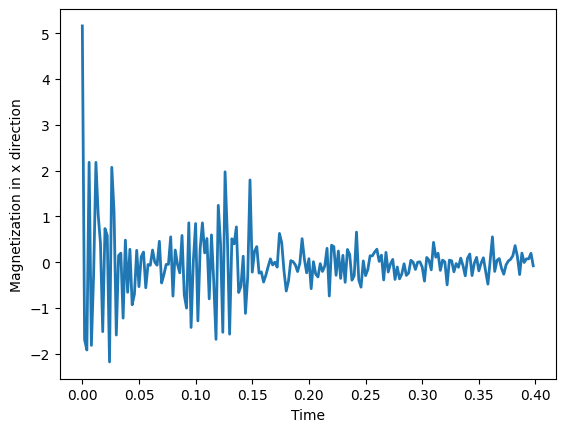

In [51]:
plt.figure(dpi=100)
plt.plot(times, Cxx_norm, color="C0", lw=2.0)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Magnetization in x direction", fontsize=10)
plt.show()

In [52]:
# Larmor/reference frequency in Hz at the given field.
reference_energy_hz = GYROMAGNETIC_RATIOS[isotope_1H] * field_T / (2 * np.pi)

# Conversion factor to go from Hz to ppm at this field: ppm = (Hz) * (1e6 / v0)
Hz_to_ppm_conversion = 1e6 / reference_energy_hz

spectrum_full, ppm = time_signal_to_spectrum(
    Cxx_norm,
    Cyx_norm,
    trotter_timestep,
    number_of_trottersteps,
    Hz_to_ppm_conversion=Hz_to_ppm_conversion,
    chem_shift_hz=chemical_shift_hz,
)

# spectrum_full, ppm = time_signal_to_spectrum(
#     Cxx_trace,
#     Cyx_trace,
#     trotter_timestep,
#     number_of_trottersteps,
#     Hz_to_ppm_conversion=Hz_to_ppm_conversion,
#     chem_shift_hz=chemical_shift_hz,
# )

In [53]:
solver_settings = hqs_nmr.NMRSolverSettings()
calculation_parameters = hqs_nmr.NMRCalculationParameters(
    field_T=field_T,
    fwhm_Hz=1.0,
    solver_settings=solver_settings,
)
result_spectrum_exact = hqs_nmr.calculate.calculate_spectrum(
    molecule_parameters=parameters, calculation_parameters=calculation_parameters
)

hqs_spectrum_tools_ppm = result_spectrum_exact.spectrum.omegas_ppm
hqs_spectrum_tools_spectrum = np.sum(result_spectrum_exact.spectrum.spin_contributions, axis=0)
hqs_spectrum_tools_spectrum /= np.max(hqs_spectrum_tools_spectrum)

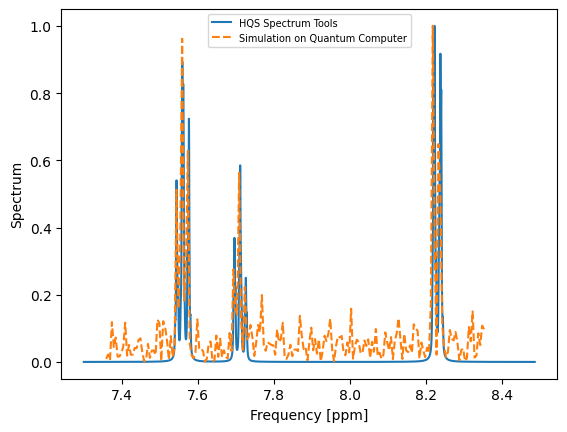

In [56]:
plt.figure(dpi=100)
plt.plot(
    hqs_spectrum_tools_ppm, hqs_spectrum_tools_spectrum, color="C0", label="HQS Spectrum Tools"
)
plt.plot(ppm, spectrum_full, color="C1", ls="--", label="Simulation on Quantum Computer")
# plt.plot(ppm_0, spectrum_full_0, color="C4", ls="--", label="Alternative")

# plt.xlim(6.2, 6.5)
plt.xlabel("Frequency [ppm]")
plt.ylabel("Spectrum")
plt.legend(fontsize=7)
plt.show()